# Imports

In [1]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.6 MB/s 


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import keras.utils.vis_utils as vis_utils 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Mount drive w/ dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!mkdir /content/dataset

In [5]:
!unzip '/content/drive/MyDrive/datasets/cats_and_dogs/cats_and_dogs.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/datasets/cats_and_dogs/cats_and_dogs.zip
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2083.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2055.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2004.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2098.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2064.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2069.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2089.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2061.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2063.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2049.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2096.jpg  
  inflating: /content/dataset/cats_and_dogs/test/cats/cat.2060.jpg  
  inflating: /content/dataset/cats_and_dogs/test/dogs/dog.2082.jpg  
  inflating: /content/dataset

# Hyperparameters Setup

In [6]:
NUM_CLASSES = 2
INPUT_SHAPE = (32, 32, 3)
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 20 # change to 100
IMAGE_SIZE = 72  # We'll resize input images to this size
PATCH_SIZE = 6  # Size of the patches to be extract from the input images
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]  # Size of the transformer layers
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]  # Size of the dense layers of the final classifier


# Model Setup

In [9]:
DF_TRAIN = '/content/dataset/cats_and_dogs/train'
DF_VALID = '/content/dataset/cats_and_dogs/validation'
DF_TEST  = '/content/dataset/cats_and_dogs/test'

# images generator
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          #  samplewise_center = True,
                                                          #  samplewise_std_normalization = True,
                                                          #  validation_split = 0.2
                                                           )

# load training and validating images from directory
train_set = data_gen.flow_from_directory(DF_TRAIN,
                                        #  subset = 'training',
                                         seed = 1,
                                         color_mode = 'rgb',
                                         shuffle = True,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

valid_set = data_gen.flow_from_directory(DF_VALID,
                                        #  subset = 'validation',
                                         seed = 1,
                                         color_mode = 'rgb',
                                         shuffle = True,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')


test_set  = data_gen.flow_from_directory(DF_TEST,
                                         seed = 1,
                                         color_mode = 'rgb',
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = None)

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


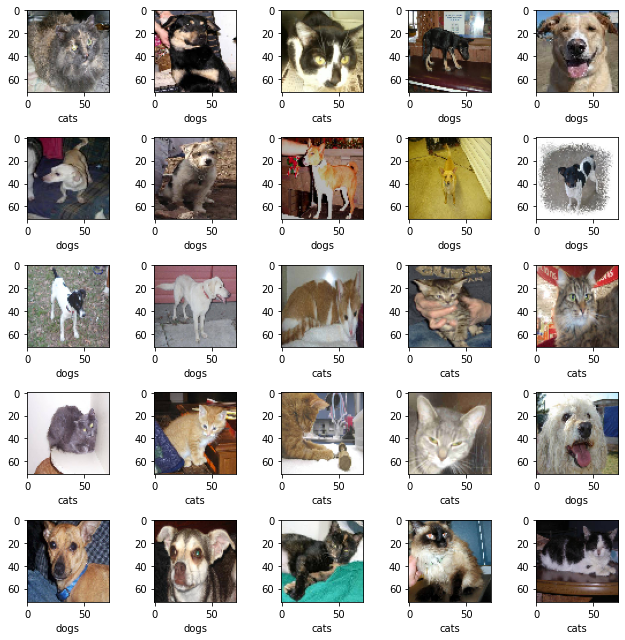

In [25]:
CLASSES = ['dogs', 'cats']

images, labels = next(train_set)[:25]
fig, axes = plt.subplots(5, 5, figsize=(9, 9))
for img, label, ax in zip(images, labels, axes.flatten()):
    ax.imshow(img)
    ax.set_xlabel(list(train_set.class_indices)[label.astype(int)])
plt.tight_layout()
plt.show()

# Data Augmentation

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

# MLP

In [27]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement Patches Image Creator


In [28]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Display a Image Sample Patch

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


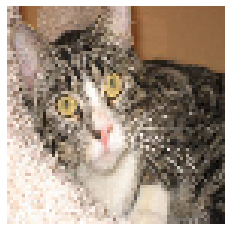

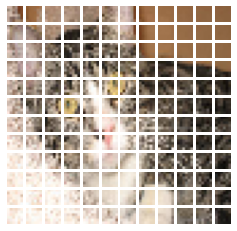

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))

images = next(train_set)[0][:1]
image = images[0]

plt.imshow(image, vmin=0, vmax=255)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

patches = Patches(PATCH_SIZE)(resized_image)
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

# Patch Encoder Layer

In [31]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build ViT Model

In [32]:
def create_vit_classifier():
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(PATCH_SIZE)(augmented)
    # patches = Patches(PATCH_SIZE)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units = TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units = MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, Train and Evaluate Model

In [33]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    model.fit(x = train_set,
              batch_size = BATCH_SIZE,
              epochs = NUM_EPOCHS,
              validation_data = valid_set,
              callbacks = checkpoint_callback
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x = train_set)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model

In [34]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_2 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_2[0][0]']              
                                                                                              

# Visualize Model

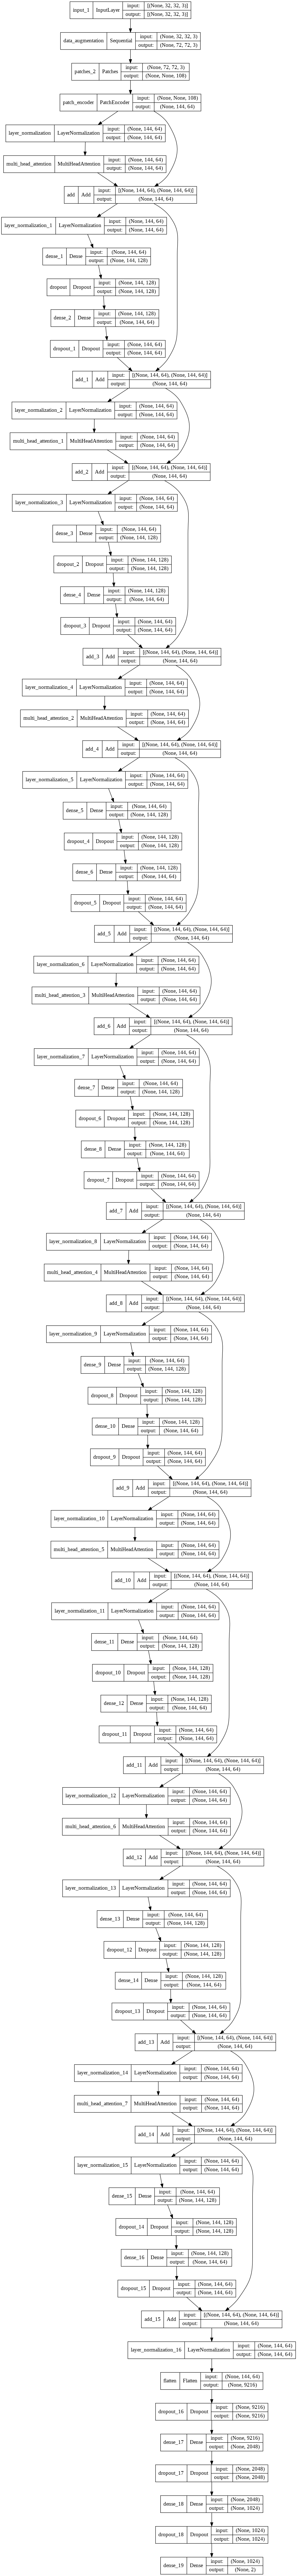

In [41]:
vis_utils.plot_model(vit_classifier, show_shapes=True, )

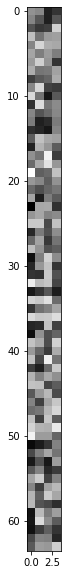

In [56]:
top_layer = vit_classifier.layers[5]
plt.figure(figsize=(10, 10))
plt.imshow(top_layer.get_weights()[0][:, :, 1].squeeze(), cmap='gray')

In [35]:
model = run_experiment(vit_classifier)

Epoch 1/20
8/8 [==============================] - 21s 1s/step - loss: 10.1116 - accuracy: 0.5015 - top-5-accuracy: 1.0000 - val_loss: 0.7102 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000
Epoch 2/20
8/8 [==============================] - 8s 974ms/step - loss: 1.4148 - accuracy: 0.4750 - top-5-accuracy: 1.0000 - val_loss: 0.9079 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000
Epoch 3/20
8/8 [==============================] - 8s 980ms/step - loss: 0.9440 - accuracy: 0.5075 - top-5-accuracy: 1.0000 - val_loss: 0.7035 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000
Epoch 4/20
8/8 [==============================] - 8s 1s/step - loss: 0.8096 - accuracy: 0.5045 - top-5-accuracy: 1.0000 - val_loss: 0.6924 - val_accuracy: 0.5260 - val_top-5-accuracy: 1.0000
Epoch 5/20
8/8 [==============================] - 8s 967ms/step - loss: 0.7741 - accuracy: 0.5130 - top-5-accuracy: 1.0000 - val_loss: 0.6962 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000
Epoch 6/20
8/8 [==================

# Results

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.82      0.66       100
           1       0.65      0.34      0.45       100

    accuracy                           0.58       200
   macro avg       0.60      0.58      0.55       200
weighted avg       0.60      0.58      0.55       200

Confusion Matrix


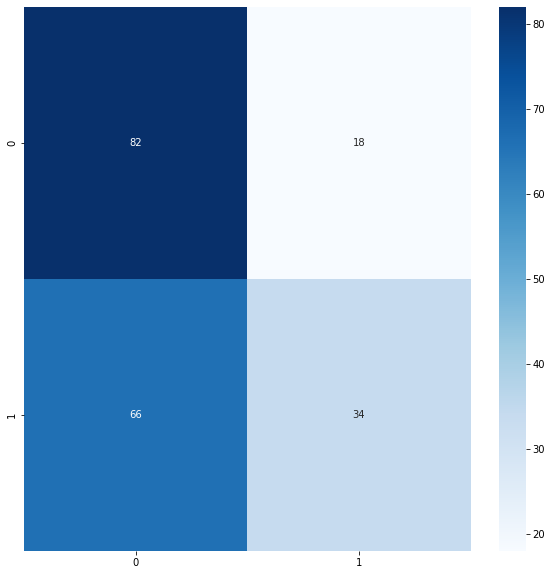

In [37]:
predicted_classes = np.argmax(model.predict(test_set, steps = test_set.n // test_set.batch_size + 1), axis = 1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())  

print("Classification Report")
print(classification_report(true_classes, predicted_classes))

print("Confusion Matrix")
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)